# Text Classification with Word2Vec embeddings and **RNN-LSTM-GRU-BiLSTM** on ***KERAS***

Comparativa evolución de modelos más básicos de clasificación de texto integrados con Wandb para visualización. 

- Añadida capa de atención basada en Bandanhau 2015 a todos para comparar la mejora que supone (tanto para LSTM como BiLSTM)



#Librerías

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
%%capture
!pip install keras
np.random.seed(0)
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
import os
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import RMSprop, SGD, Adam, Nadam


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
# Need
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *

In [ ]:
%%capture
!pip install wandb 
import wandb
from wandb.keras import WandbCallback

In [ ]:
%%capture

!pip install attention

# Carga dataset Amazon

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/TFG/Datasets_procesados_2/train/amazonEN_train.csv')
df_valid = pd.read_csv('/content/drive/MyDrive/TFG/Datasets_procesados_2/valid/amazonEN_valid.csv')
df_test = pd.read_csv('/content/drive/MyDrive/TFG/Datasets_procesados_2/test/amazonEN_test.csv')
df_train.head(1)

,review_id,product_id,reviewer_id,star_rating,review_body,review_title,language,product_category,text_title,text_title_cat,text_cat,product_category_cod
0,en_0522546,product_en_0681589,reviewer_en_0687817,2,Not strong enough to run a small 120v vacuum c...,Not strong enough to run a small 120v vacuum c...,en,lawn_and_garden,Not strong enough to run a small 120v vacuum c...,Not strong enough to run a small 120v vacuum c...,Not strong enough to run a small 120v vacuum c...,17


In [ ]:
## Función para tokenizar, codificar y realizar el padding sobre las reviews 

def preprocess(X_train,X_val,X_test,y_train,y_val,y_test):
 
  ## Tokenize reviews
  X_data_full = pd.concat([X_train, X_val, X_test],ignore_index=True)
  t= Tokenizer()
  t.fit_on_texts(X_data_full)
  vocab_size = len(t.word_index)+1
  max_length = 260

  # Cod and pad reviews
  encoded_rev = t.texts_to_sequences(X_train)
  padded_rev = pad_sequences(encoded_rev,maxlen=max_length,padding= 'post')

  encoded_rev_val = t.texts_to_sequences(X_val)
  padded_rev_val = pad_sequences(encoded_rev_val,maxlen=max_length,padding= 'post')

  encoded_rev_test = t.texts_to_sequences(X_test)
  padded_rev_test = pad_sequences(encoded_rev_test,maxlen=max_length,padding= 'post')

  return t, vocab_size, padded_rev, padded_rev_val, padded_rev_test

# Carga Dato Chatbot

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/dato_chatbot_procesado/train/rep_trainES.csv')
df_valid = pd.read_csv('/content/drive/MyDrive/dato_chatbot_procesado/valid/rep_validES.csv')
df_test = pd.read_csv('/content/drive/MyDrive/dato_chatbot_procesado/test/rep_testES.csv')
df_train.head()

,Query,category_cod
0,cambio de contraseña y no reconoce credenciale...,5
1,necesito ayuda sobre la configuración del buzó...,6
2,quiero restaurar un archivo de un departamental,23
3,solicitar buzón correo compartido,6
4,problema acceso a teams con mi movil,32


In [ ]:
len(df_train.category_cod.unique())

39

# Carga Embeddings Word2Vec

In [ ]:
# Descarga vectores Word2Vec no contextuales:  (100 / palabra )

def read_word2vec_vecs(file):
        with open(file, 'r',  errors='ignore', encoding="utf-8") as f:
            words = set()
            word_to_vec_map = {}
            for line in f:
                line = line.strip().split()
                curr_word_list = line[0: len(line) - 100]
                curr_word = ""
                for t in curr_word_list:
                    curr_word = curr_word + str(t) + " "
                curr_word = curr_word.strip()
                words.add(curr_word)
                try:
                    word_to_vec_map[curr_word] = np.array(line[-100:], dtype=np.float64)
                except:
                    print(line, len(line))

            i = 1
            words_to_index = {}
            index_to_words = {}

            words.add("nokey")
            word_to_vec_map["nokey"] = np.zeros((100,), dtype=np.float64)

            for w in sorted(words):
                words_to_index[w] = i
                index_to_words[i] = w
                i = i + 1
        return words_to_index, index_to_words, word_to_vec_map

In [ ]:
%%capture
Pathdrive = "/content/drive/MyDrive/word2vec/model.txt"

words_to_index, index_to_words, word_to_vec_map = read_word2vec_vecs(Pathdrive)

In [ ]:
# nº Embeddings palabra "no"
len(word_to_vec_map["no"]) 

100

In [ ]:
# Tamaño del vocabulario de ingles
len(words_to_index)

4027170

# Wandb log


In [ ]:
# Initialize wandb with your project name
run = wandb.init(project='RNN-LSTM-GRU-BiLSTM Models -CHATBOT',
                 group = 'Category-query',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.001,
                     "epochs": 10,
                     "batch_size": 64,
                     "loss_function": "sparse_categorical_crossentropy",
                     "architecture": "RNN"
                 })
config = wandb.config  # We'll use this to configure our experiment

epoch,9
loss,3.16719
accuracy,0.13971
val_loss,3.24917
val_accuracy,0.10526
_runtime,444
_timestamp,1617212570
_step,9
best_val_loss,3.11719
best_epoch,5


epoch,▁▂▃▃▄▅▆▆▇█
loss,██▅▃▂▂▁▁▁▁
accuracy,▁▁▇█▆▅▆▇██
val_loss,█▆▄▂▁▁▂▂▂▃
val_accuracy,▁██▆███▆▆▆
_runtime,▁▂▂▃▄▅▆▇▇█
_timestamp,▁▂▂▃▄▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█


# Modelo RNN

In [ ]:
X_train = df_train['Query']
X_val= df_valid['Query']
X_test= df_test['Query']

y_train = df_train['category_cod']
y_val = df_valid['category_cod']
y_test= df_test['category_cod']

# Aplicamos pre-procesado 
t, vocab_size, padded_rev, padded_rev_val, padded_rev_test = preprocess(X_train,X_val,X_test,y_train,y_val,y_test)

In [ ]:
# Creamos matriz de embeddings a partir del vocab de las review_body y los embeddings MUSE,  FULL
from numpy import zeros
embedding_matrix = zeros((vocab_size,100))
for word, i in t.word_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(975, 100)

In [ ]:
# Modelo RNN 
from keras.layers import SimpleRNN

model = Sequential()
embed = Embedding(vocab_size,100,weights = [embedding_matrix], input_length=260,trainable=False)
model.add(embed)
model.add(SimpleRNN(128,return_sequences=False))
model.add(Dense(39,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 260, 100)          97500     
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 128)               29312     
_________________________________________________________________
dense_3 (Dense)              (None, 39)                5031      
Total params: 131,843
Trainable params: 34,343
Non-trainable params: 97,500
_________________________________________________________________


In [ ]:
model.compile(loss=config.loss_function, optimizer=Adam(lr=config.learning_rate), metrics=['accuracy'])

In [ ]:
model.fit(padded_rev, y_train, epochs=10, 
          batch_size= 64, shuffle=True, 
              validation_data=(padded_rev_val, y_val), callbacks= [WandbCallback()])

Epoch 1/10
7/7 [==============================] - 3s 279ms/step - loss: 3.6786 - accuracy: 0.0075 - val_loss: 3.7782 - val_accuracy: 0.0000e+00
Epoch 2/10
7/7 [==============================] - 2s 244ms/step - loss: 3.6654 - accuracy: 0.0351 - val_loss: 3.4896 - val_accuracy: 0.1053
Epoch 3/10
7/7 [==============================] - 2s 237ms/step - loss: 3.4562 - accuracy: 0.0526 - val_loss: 3.3130 - val_accuracy: 0.1579
Epoch 4/10
7/7 [==============================] - 2s 244ms/step - loss: 3.2766 - accuracy: 0.1288 - val_loss: 3.1832 - val_accuracy: 0.1579
Epoch 5/10
7/7 [==============================] - 2s 242ms/step - loss: 3.2367 - accuracy: 0.1124 - val_loss: 3.1527 - val_accuracy: 0.1053
Epoch 6/10
7/7 [==============================] - 2s 232ms/step - loss: 3.1741 - accuracy: 0.1241 - val_loss: 3.1534 - val_accuracy: 0.1053
Epoch 7/10
7/7 [==============================] - 2s 242ms/step - loss: 3.1161 - accuracy: 0.1115 - val_loss: 3.1969 - val_accuracy: 0.1053
Epoch 8/10
7/7 [

In [ ]:
## Función test dato  
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def eval_model(model,test_data,test_labels):

  """
  Recibe el modelo, el dato de test ya procesado (x idioma) y las true labels
  """
  loss,acc = model.evaluate(x=test_data, 
                                        y=test_labels, 
                                        batch_size=64, 
                                        verbose=1)
  
  
  predictions = model.predict(test_data)
  matrix = confusion_matrix(test_labels, predictions.argmax(axis=1))
  plt.figure(figsize = (10,7))
  ## Confusion matrix with counts
  sns.heatmap(matrix, annot=True,cmap='Oranges',fmt='g')

  #sns.heatmap(matrix/np.sum(matrix), annot=True, 
   #          fmt='.2%', cmap='Oranges')
  plt.xlabel("Predicted class")
  plt.ylabel("True class") 

  clas_report = classification_report(test_labels, predictions.argmax(axis=1))

  return print(clas_report)

1/1 [==============================] - 0s 44ms/step - loss: 3.9817 - accuracy: 0.0000e+00
              precision    recall  f1-score   support

           6       0.00      0.00      0.00       0.0
          22       0.00      0.00      0.00       1.0
          24       0.00      0.00      0.00       1.0
          28       0.00      0.00      0.00       1.0

    accuracy                           0.00       3.0
   macro avg       0.00      0.00      0.00       3.0
weighted avg       0.00      0.00      0.00       3.0



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


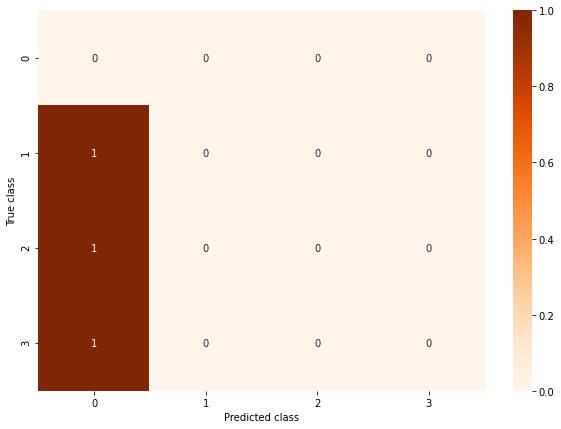

In [ ]:
eval_model(model,padded_rev_test,y_test)

# Modelo LSTM / GRU

In [ ]:
X_train = df_train['review_body']
X_val= df_valid['review_body']
X_test= df_test['review_body']

y_train = df_train['product_category_cod']
y_val = df_valid['product_category_cod']
y_test= df_test['product_category_cod']

# Aplicamos pre-procesado 
t, vocab_size, padded_rev, padded_rev_val, padded_rev_test = preprocess(X_train,X_val,X_test,y_train,y_val,y_test)

In [ ]:
# Creamos matriz de embeddings a partir del vocab de las review_body y los embeddings MUSE,  FULL
from numpy import zeros
embedding_matrix = zeros((vocab_size,100))
for word, i in t.word_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(47071, 100)

In [ ]:
# Modelo LSTM 
from keras.layers import LSTM

modellstm= Sequential()
embed = Embedding(vocab_size,100,weights = [embedding_matrix], input_length=260,trainable=False)
modellstm.add(embed)
modellstm.add(LSTM(128,return_sequences=False))
modellstm.add(Dense(31,activation='softmax'))

In [ ]:
modellstm.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 260, 100)          4868100   
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dense_21 (Dense)             (None, 31)                3999      
Total params: 4,989,347
Trainable params: 121,247
Non-trainable params: 4,868,100
_________________________________________________________________


In [ ]:
modellstm.compile(loss=config.loss_function, optimizer=Adam(lr=config.learning_rate), metrics=['accuracy'])

In [ ]:
modellstm.fit(padded_rev, y_train, epochs=10, 
          batch_size= 64, shuffle=True, 
          validation_data=(padded_rev_val, y_val),
          callbacks = [WandbCallback()]
          )

Epoch 1/10
3125/3125 [==============================] - 54s 17ms/step - loss: 3.1647 - accuracy: 0.0825 - val_loss: 3.1653 - val_accuracy: 0.0928
Epoch 2/10
3125/3125 [==============================] - 52s 17ms/step - loss: 3.1532 - accuracy: 0.0876 - val_loss: 3.1642 - val_accuracy: 0.0928
Epoch 3/10
3125/3125 [==============================] - 52s 17ms/step - loss: 3.1478 - accuracy: 0.0885 - val_loss: 2.8781 - val_accuracy: 0.1596
Epoch 4/10
3125/3125 [==============================] - 53s 17ms/step - loss: 2.7063 - accuracy: 0.2083 - val_loss: 2.4275 - val_accuracy: 0.2812
Epoch 5/10
3125/3125 [==============================] - 52s 17ms/step - loss: 2.3826 - accuracy: 0.2968 - val_loss: 2.4295 - val_accuracy: 0.2964
Epoch 6/10
3125/3125 [==============================] - 52s 17ms/step - loss: 2.2678 - accuracy: 0.3429 - val_loss: 2.1612 - val_accuracy: 0.3788
Epoch 7/10
3125/3125 [==============================] - 53s 17ms/step - loss: 2.1104 - accuracy: 0.3931 - val_loss: 2.0831 -

40/40 [==============================] - 1s 12ms/step - loss: 1.8305 - accuracy: 0.4712


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.50      0.80      0.61       192
           1       0.54      0.53      0.53       100
           2       0.33      0.29      0.31        35
           3       0.48      0.57      0.52       152
           4       0.65      0.44      0.53        54
           5       0.83      0.20      0.32        25
           6       0.80      0.88      0.84        84
           7       0.67      0.57      0.62        21
           8       0.43      0.40      0.41       143
           9       0.40      0.34      0.36        80
          10       0.44      0.35      0.39        31
          11       0.67      0.60      0.63        50
          12       0.26      0.47      0.34       208
          13       0.48      0.38      0.42        89
          14       0.00      0.00      0.00        29
          15       0.71      0.45      0.56        44
          16       0.55      0.50      0.52       128
          17       0.39    

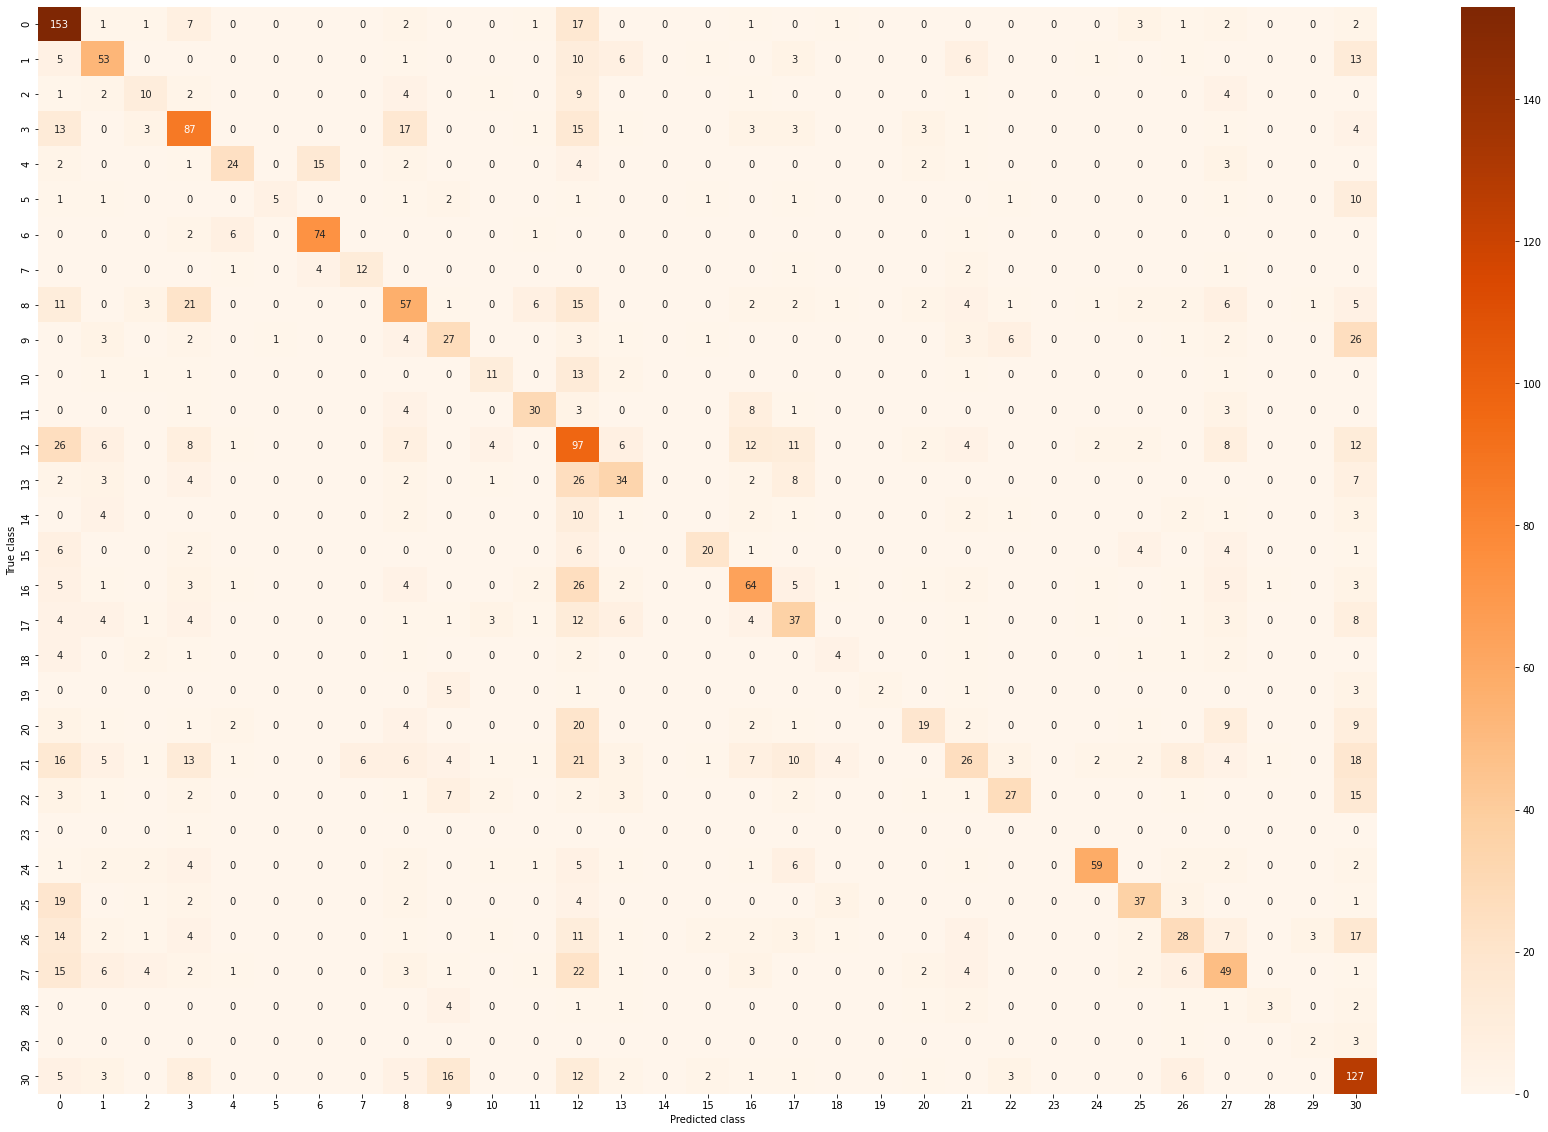

In [ ]:
eval_model(modellstm,padded_rev_test,y_test)

In [ ]:
wandb.finish()

epoch,9
loss,2.25354
accuracy,0.34736
val_loss,2.22726
val_accuracy,0.3568
_runtime,546
_timestamp,1617109072
_step,9
best_val_loss,2.22726
best_epoch,9


epoch,▁▂▃▃▄▅▆▆▇█
loss,████▅▄▄▃▂▁
accuracy,▁▁▁▁▄▅▅▆▇█
val_loss,███▇▄▄▄▃▂▁
val_accuracy,▁▁▁▂▅▅▅▆▇█
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


# Modelo Bi-LSTM 

In [ ]:
X_train = df_train['review_body']
X_val= df_valid['review_body']
X_test= df_test['review_body']

y_train = df_train['product_category_cod']
y_val = df_valid['product_category_cod']
y_test= df_test['product_category_cod']


# Aplicamos pre-procesado 
t, vocab_size, padded_rev, padded_rev_val, padded_rev_test = preprocess(X_train,X_val,X_test,y_train,y_val,y_test)

In [ ]:
# Creamos matriz de embeddings a partir del vocab de las review_body y los embeddings MUSE,  FULL
from numpy import zeros
embedding_matrix = zeros((vocab_size,100))
for word, i in t.word_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(48681, 100)

In [ ]:
# Modelo BiLSTM 
from keras.layers import Bidirectional

modelbi = Sequential()
embed = Embedding(vocab_size,100,weights = [embedding_matrix], input_length=260,trainable=False)
modelbi.add(embed)
modelbi.add(Bidirectional(LSTM(128,return_sequences=False)))
modelbi.add(Dense(31,activation='softmax'))

In [ ]:
modelbi.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 260, 100)          4868100   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               234496    
_________________________________________________________________
dense_23 (Dense)             (None, 31)                7967      
Total params: 5,110,563
Trainable params: 242,463
Non-trainable params: 4,868,100
_________________________________________________________________


In [ ]:
modelbi.compile(loss=config.loss_function, optimizer=Adam(learning_rate=config.learning_rate), metrics=['accuracy'])

In [ ]:
modelbi.fit(padded_rev, y_train, epochs=10, 
          batch_size= 64, shuffle=True, 
              validation_data=(padded_rev_val, y_val),
          callbacks = [WandbCallback()]
          )

Epoch 1/10
3125/3125 [==============================] - 97s 30ms/step - loss: 2.5013 - accuracy: 0.2807 - val_loss: 1.9762 - val_accuracy: 0.4316
Epoch 2/10
3125/3125 [==============================] - 96s 31ms/step - loss: 1.9678 - accuracy: 0.4367 - val_loss: 1.8721 - val_accuracy: 0.4500
Epoch 3/10
3125/3125 [==============================] - 95s 30ms/step - loss: 1.8296 - accuracy: 0.4708 - val_loss: 1.8303 - val_accuracy: 0.4692
Epoch 4/10
3125/3125 [==============================] - 96s 31ms/step - loss: 1.7770 - accuracy: 0.4844 - val_loss: 1.7884 - val_accuracy: 0.4832
Epoch 5/10
3125/3125 [==============================] - 97s 31ms/step - loss: 1.7372 - accuracy: 0.4942 - val_loss: 1.7849 - val_accuracy: 0.4852
Epoch 6/10
3125/3125 [==============================] - 97s 31ms/step - loss: 1.6917 - accuracy: 0.5067 - val_loss: 1.7790 - val_accuracy: 0.4848
Epoch 7/10
3125/3125 [==============================] - 96s 31ms/step - loss: 1.6615 - accuracy: 0.5151 - val_loss: 1.7666 -

40/40 [==============================] - 1s 14ms/step - loss: 1.7374 - accuracy: 0.4976


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.56      0.78      0.65       192
           1       0.46      0.46      0.46       100
           2       0.41      0.26      0.32        35
           3       0.53      0.58      0.56       152
           4       0.68      0.46      0.55        54
           5       0.60      0.24      0.34        25
           6       0.79      0.90      0.84        84
           7       0.67      0.57      0.62        21
           8       0.37      0.44      0.40       143
           9       0.41      0.34      0.37        80
          10       0.52      0.39      0.44        31
          11       0.52      0.62      0.56        50
          12       0.35      0.41      0.38       208
          13       0.39      0.40      0.40        89
          14       0.00      0.00      0.00        29
          15       0.82      0.52      0.64        44
          16       0.57      0.62      0.60       128
          17       0.43    

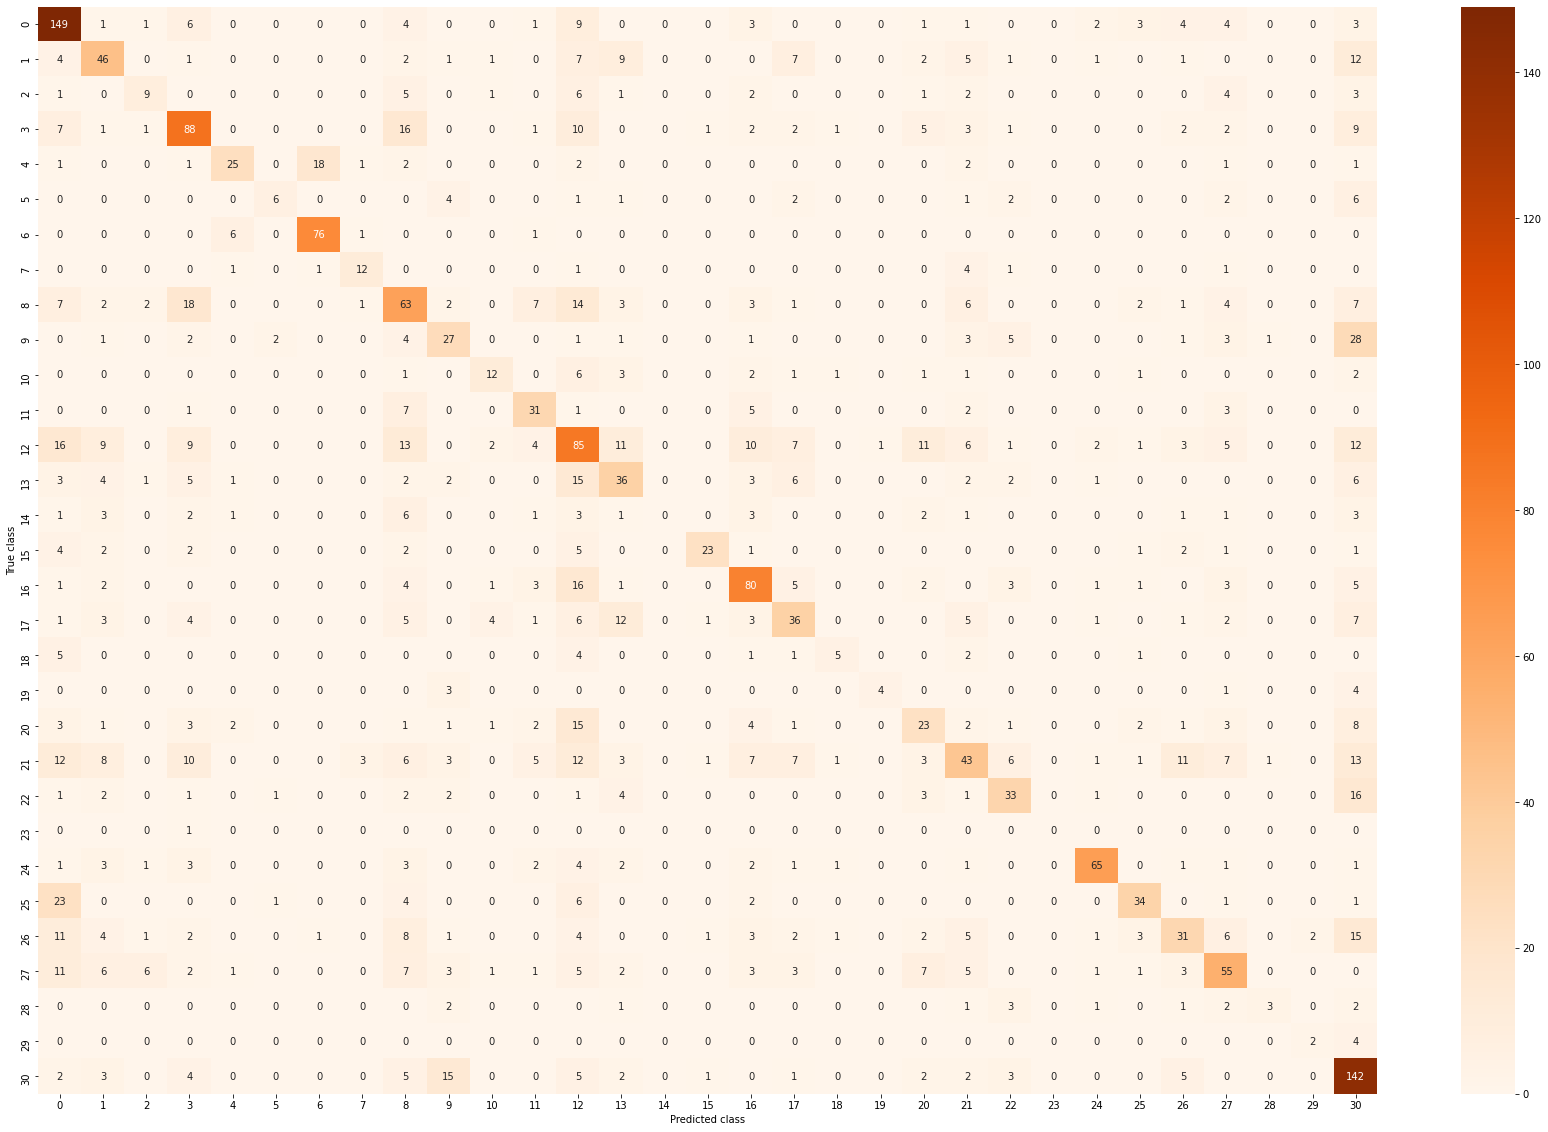

In [ ]:
eval_model(modelbi,padded_rev_test,y_test)

In [ ]:
wandb.finish()

epoch,9
loss,1.59058
accuracy,0.5333
val_loss,1.76966
val_accuracy,0.4876
_runtime,963
_timestamp,1617116607
_step,9
best_val_loss,1.76289
best_epoch,7


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▂▁▁
accuracy,▁▅▆▆▆▇▇███
val_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▃▅▇▇▇▇█▇▇
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


# Add Attention Layer 
- from package imported from github


In [ ]:
X_train = df_train['review_body']
X_val= df_valid['review_body']
X_test= df_test['review_body']

y_train = df_train['star_rating']
y_val = df_valid['star_rating']
y_test= df_test['star_rating']

# Aplicamos pre-procesado 
t, vocab_size, padded_rev, padded_rev_val, padded_rev_test = preprocess(X_train,X_val,X_test,y_train,y_val,y_test)

In [ ]:
# Creamos matriz de embeddings a partir del vocab de las review_body y los embeddings MUSE,  FULL
from numpy import zeros
embedding_matrix = zeros((vocab_size,100))
for word, i in t.word_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
# Modelo LSTM 
from keras.layers import LSTM
from attention import Attention

model = Sequential()
embed = Embedding(vocab_size,100,weights = [embedding_matrix], input_length=260,trainable=False)
model.add(embed)
model.add(LSTM(128,return_sequences=True))
model.add(Attention(32))
model.add(Dense(5,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 260, 100)          4707100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 260, 128)          117248    
_________________________________________________________________
last_hidden_state (Lambda)   (None, 128)               0         
_________________________________________________________________
attention_score_vec (Dense)  (None, 260, 128)          16384     
_________________________________________________________________
attention_score (Dot)        (None, 260)               0         
_________________________________________________________________
attention_weight (Activation (None, 260)               0         
_________________________________________________________________
context_vector (Dot)         (None, 128)              

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(lr=0.001), metrics=['accuracy'])

In [ ]:
model.fit(padded_rev, y_train, epochs=10, 
          batch_size= 64, shuffle=True, 
              validation_data=(padded_rev_val, y_val))

Epoch 1/10
3125/3125 [==============================] - 91s 19ms/step - loss: 1.3308 - accuracy: 0.4015 - val_loss: 1.1210 - val_accuracy: 0.5088
Epoch 2/10
3125/3125 [==============================] - 60s 19ms/step - loss: 1.0954 - accuracy: 0.5227 - val_loss: 1.0793 - val_accuracy: 0.5216
Epoch 3/10
3125/3125 [==============================] - 61s 19ms/step - loss: 1.0495 - accuracy: 0.5412 - val_loss: 1.0495 - val_accuracy: 0.5456
Epoch 4/10
3125/3125 [==============================] - 61s 19ms/step - loss: 1.0167 - accuracy: 0.5536 - val_loss: 1.0301 - val_accuracy: 0.5584
Epoch 5/10
3125/3125 [==============================] - 61s 19ms/step - loss: 0.9906 - accuracy: 0.5645 - val_loss: 1.0218 - val_accuracy: 0.5456
Epoch 6/10
3125/3125 [==============================] - 61s 19ms/step - loss: 0.9654 - accuracy: 0.5763 - val_loss: 1.0179 - val_accuracy: 0.5604
Epoch 7/10
3125/3125 [==============================] - 60s 19ms/step - loss: 0.9498 - accuracy: 0.5831 - val_loss: 1.0163 -

40/40 [==============================] - 0s 10ms/step - loss: 1.0357 - accuracy: 0.5600
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       480
           1       0.48      0.50      0.49       530
           2       0.48      0.38      0.42       501
           3       0.51      0.47      0.49       479
           4       0.64      0.80      0.71       510

    accuracy                           0.56      2500
   macro avg       0.55      0.56      0.55      2500
weighted avg       0.55      0.56      0.55      2500



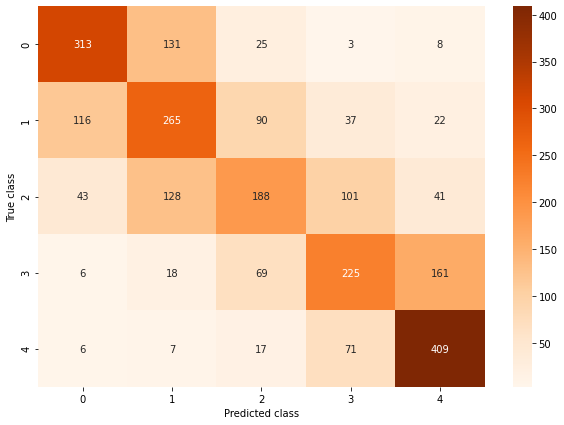

In [ ]:
eval_model(model,padded_rev_test,y_test)

# Custom Attention Layer built on KERAS for LSTM
- Based on Bahdanau Attention

In [ ]:
from keras.layers import Layer
import keras.backend as K

In [ ]:
#Banhdanau attention 

class Attention(Layer):
  def __init__(self,**kwargs):
        super(Attention,self).__init__(**kwargs)
  
  # Con la función build definimos los pesos y biases (W y b) 
  def build(self,input_shape):
    self.W = self.add_weight(name= 'attention_weight', shape=(input_shape[-1],1), initializer = 'normal')
    self.b = self.add_weight(name= 'attention_bias', shape=(input_shape[1],1), initializer = 'zeros')
    super(Attention,self).build(input_shape)

  # Con la función call definimos la lógica del mecanismo de atención y devuelve el vector de contexto
  def call(self,x): 
    et = K.squeeze(K.tanh(K.dot(x, self.W) + self.b), axis = -1)
    at = K.softmax(et)
    at = K.expand_dims(at,axis= -1)
    output = x * at
    return K.sum(output,axis=1)

  def compute_output_shape(self,input_shape):
    return(input_shape[0],input_shape[-1])

  def get_config(self):
    return super(Attention,self).get_config()


In [ ]:
modelatt = Sequential()
embed = Embedding(vocab_size,100,weights = [embedding_matrix], input_length=260,trainable=False)
modelatt.add(embed)
modelatt.add(LSTM(128,return_sequences=True))
modelatt.add(Attention())
modelatt.add(Dense(31,activation='softmax'))

In [ ]:
modelatt.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 260, 100)          4868100   
_________________________________________________________________
lstm_14 (LSTM)               (None, 260, 128)          117248    
_________________________________________________________________
attention_5 (Attention)      (None, 128)               388       
_________________________________________________________________
dense_24 (Dense)             (None, 31)                3999      
Total params: 4,989,735
Trainable params: 121,635
Non-trainable params: 4,868,100
_________________________________________________________________


In [ ]:
modelatt.compile(loss=config.loss_function, optimizer=Adam(lr=config.learning_rate), metrics=['accuracy'])

In [ ]:
modelatt.fit(padded_rev, y_train, epochs=10, 
          batch_size= 64, shuffle=True, 
              validation_data=(padded_rev_val, y_val),
             callbacks = [WandbCallback()]
             )

Epoch 1/10
3125/3125 [==============================] - 55s 17ms/step - loss: 2.6450 - accuracy: 0.2393 - val_loss: 2.0199 - val_accuracy: 0.4244
Epoch 2/10
3125/3125 [==============================] - 53s 17ms/step - loss: 1.9504 - accuracy: 0.4376 - val_loss: 1.8904 - val_accuracy: 0.4584
Epoch 3/10
3125/3125 [==============================] - 53s 17ms/step - loss: 1.8385 - accuracy: 0.4696 - val_loss: 1.8454 - val_accuracy: 0.4680
Epoch 4/10
3125/3125 [==============================] - 54s 17ms/step - loss: 1.7900 - accuracy: 0.4815 - val_loss: 1.8087 - val_accuracy: 0.4748
Epoch 5/10
3125/3125 [==============================] - 54s 17ms/step - loss: 1.7424 - accuracy: 0.4944 - val_loss: 1.8118 - val_accuracy: 0.4720
Epoch 6/10
3125/3125 [==============================] - 53s 17ms/step - loss: 1.7034 - accuracy: 0.5044 - val_loss: 1.7791 - val_accuracy: 0.4780
Epoch 7/10
3125/3125 [==============================] - 53s 17ms/step - loss: 1.6782 - accuracy: 0.5119 - val_loss: 1.7560 -

40/40 [==============================] - 1s 12ms/step - loss: 1.6921 - accuracy: 0.5060


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.56      0.79      0.66       192
           1       0.52      0.50      0.51       100
           2       0.45      0.37      0.41        35
           3       0.47      0.62      0.54       152
           4       0.77      0.37      0.50        54
           5       0.56      0.36      0.44        25
           6       0.79      0.92      0.85        84
           7       0.74      0.67      0.70        21
           8       0.44      0.40      0.42       143
           9       0.38      0.36      0.37        80
          10       0.54      0.42      0.47        31
          11       0.52      0.64      0.57        50
          12       0.30      0.50      0.38       208
          13       0.38      0.39      0.38        89
          14       0.00      0.00      0.00        29
          15       0.68      0.52      0.59        44
          16       0.63      0.62      0.62       128
          17       0.62    

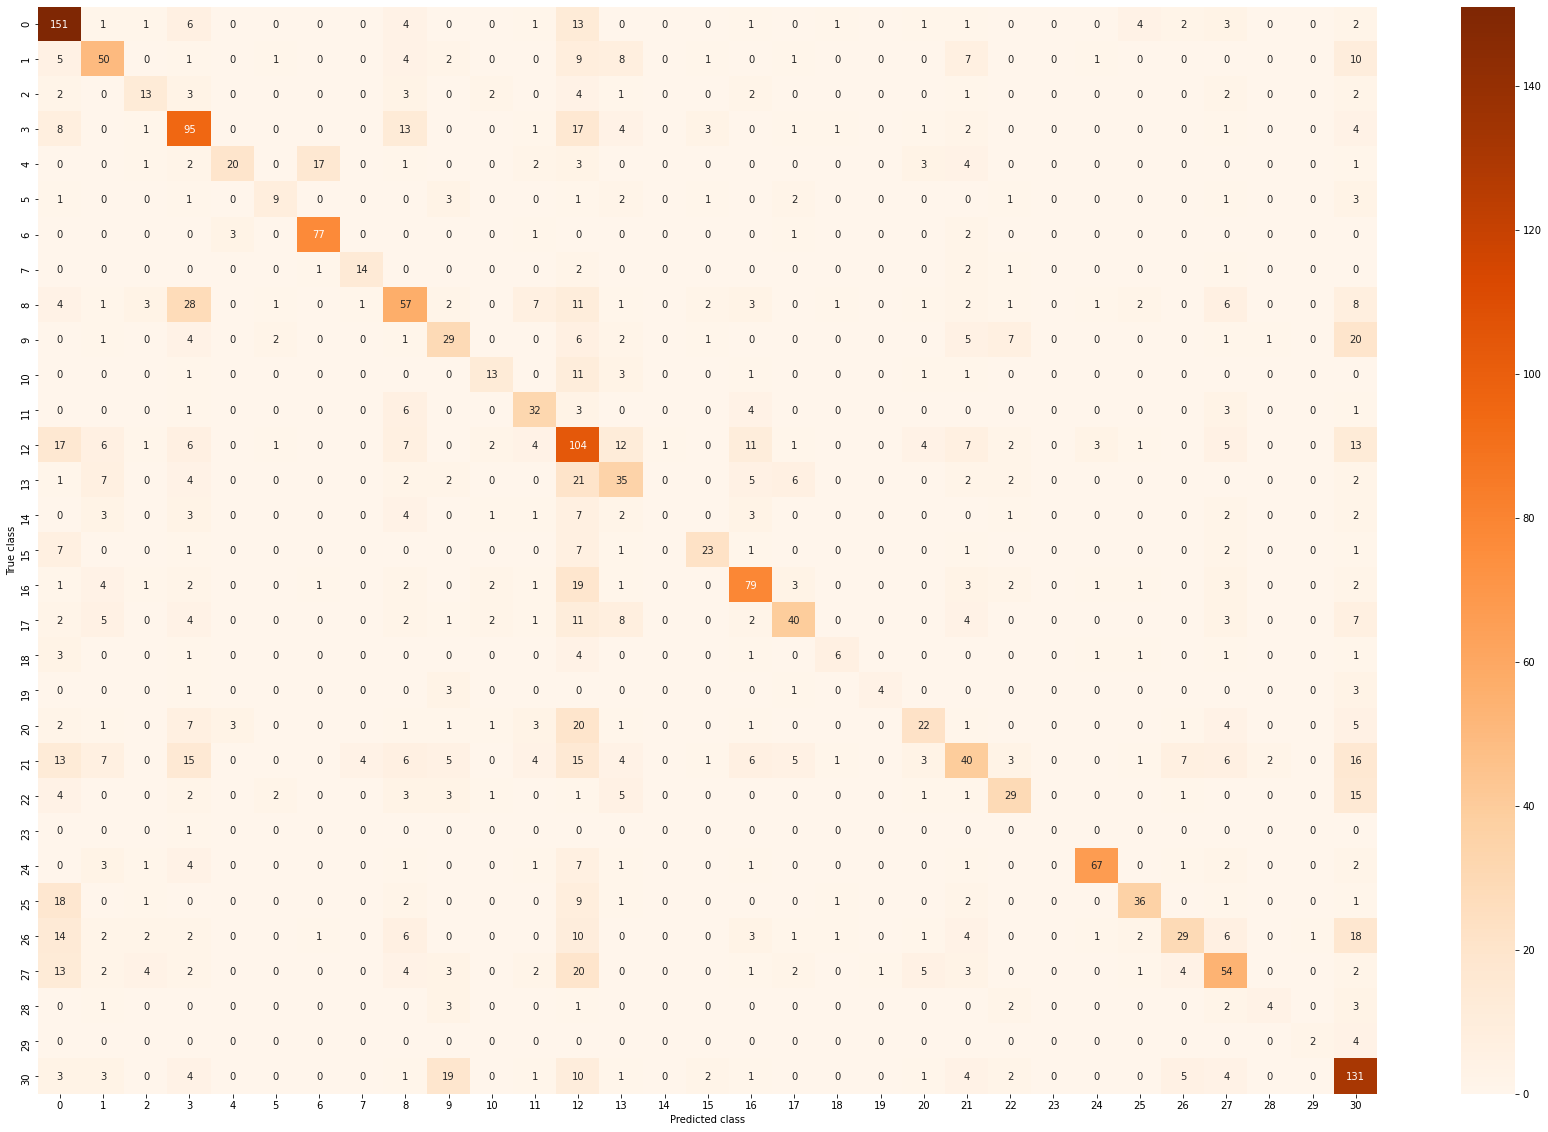

In [ ]:
eval_model(modelatt,padded_rev_test,y_test)

In [ ]:
wandb.finish()

epoch,9
loss,0.78962
accuracy,0.65527
val_loss,0.87515
val_accuracy,0.6236
_runtime,843
_timestamp,1617052876
_step,10
best_val_loss,0.87195
best_epoch,8


epoch,▁▁▂▃▃▄▅▆▆▇█
loss,█▇▄▃▃▂▂▂▁▁▁
accuracy,▁▂▅▆▆▇▇▇███
val_loss,▇▇█▃▂▂▂▂▁▁▁
val_accuracy,▁▂▂▇▆▇▇█▇██
_runtime,▁▄▄▅▅▆▆▇▇██
_timestamp,▁▄▄▅▅▆▆▇▇██
_step,▁▂▂▃▄▅▅▆▇▇█


In [ ]:
from keras.layers import Attention

#Custom Attention Layer built on KERAS for BiLSTM
Hay que concatenar los estados ocultos de las dos RNN y imponer la atención sobre los mismos

En este caso en vez de una capa de atención (Hereda de la capa keras.layers) implementamos una nuevo modelo pqueñito (una red nueva) que realiza las operaciones de atención 

In [ ]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
          
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
          
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights


In [ ]:
sequence_input = Input(shape=(260,), dtype="int32")
embedded_sequences = Embedding(vocab_size,100,weights = [embedding_matrix], input_length=260,trainable=False)(sequence_input)
bilstm = Bidirectional(LSTM(128, return_sequences = True), name="bi_lstm_0")(embedded_sequences)

# BiLSTM outputs
(bilstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(128, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)

state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
context_vector, attention_weights = Attention(10)(lstm, state_h)

dense1 = Dense(100, activation="relu")(context_vector)
dropout = Dropout(0.3)(dense1)

output = Dense(5, activation="softmax")(dropout)
  
model = keras.Model(inputs=sequence_input, outputs=output)


In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 260)]        0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 260, 100)     4707100     input_3[0][0]                    
__________________________________________________________________________________________________
bi_lstm_0 (Bidirectional)       (None, 260, 256)     234496      embedding_4[0][0]                
__________________________________________________________________________________________________
bi_lstm_1 (Bidirectional)       [(None, 260, 256), ( 394240      bi_lstm_0[0][0]                  
____________________________________________________________________________________________

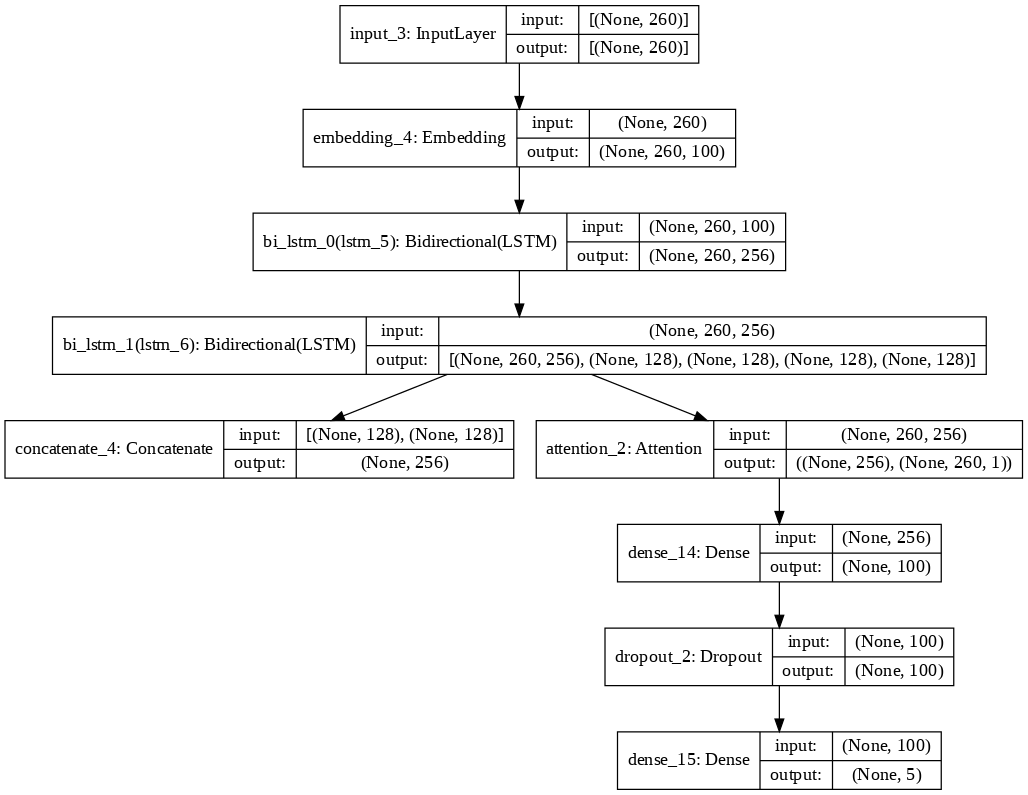

In [ ]:
keras.utils.plot_model(model, show_shapes=True, dpi=90)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

In [ ]:
X_train = df_train['review_body']
X_val= df_valid['review_body']
X_test= df_test['review_body']

y_train = df_train['star_rating']
y_val = df_valid['star_rating']
y_test= df_test['star_rating']

# Aplicamos pre-procesado 
t, vocab_size, padded_rev, padded_rev_val, padded_rev_test = preprocess(X_train,X_val,X_test,y_train,y_val,y_test)

In [ ]:
model.fit(padded_rev, y_train, epochs=10, 
          batch_size= 64, shuffle=True, 
              validation_data=(padded_rev_val, y_val))

Epoch 1/10
3125/3125 [==============================] - 209s 66ms/step - loss: 1.2817 - accuracy: 0.4286 - val_loss: 1.0931 - val_accuracy: 0.5100
Epoch 2/10
3125/3125 [==============================] - 205s 66ms/step - loss: 1.0710 - accuracy: 0.5306 - val_loss: 1.0352 - val_accuracy: 0.5384
Epoch 3/10
3125/3125 [==============================] - 204s 65ms/step - loss: 1.0071 - accuracy: 0.5605 - val_loss: 1.0039 - val_accuracy: 0.5436
Epoch 4/10
3125/3125 [==============================] - 205s 66ms/step - loss: 0.9736 - accuracy: 0.5737 - val_loss: 0.9896 - val_accuracy: 0.5592
Epoch 5/10
3125/3125 [==============================] - 204s 65ms/step - loss: 0.9399 - accuracy: 0.5875 - val_loss: 0.9926 - val_accuracy: 0.5556
Epoch 6/10
3125/3125 [==============================] - 205s 66ms/step - loss: 0.9102 - accuracy: 0.5998 - val_loss: 0.9977 - val_accuracy: 0.5664
Epoch 7/10
3125/3125 [==============================] - 204s 65ms/step - loss: 0.8788 - accuracy: 0.6137 - val_loss: 0

40/40 [==============================] - 1s 29ms/step - loss: 2.0430 - accuracy: 0.5152
              precision    recall  f1-score   support

           0       0.56      0.67      0.61       480
           1       0.47      0.35      0.40       530
           2       0.40      0.44      0.42       501
           3       0.46      0.44      0.45       479
           4       0.67      0.68      0.67       510

    accuracy                           0.52      2500
   macro avg       0.51      0.52      0.51      2500
weighted avg       0.51      0.52      0.51      2500



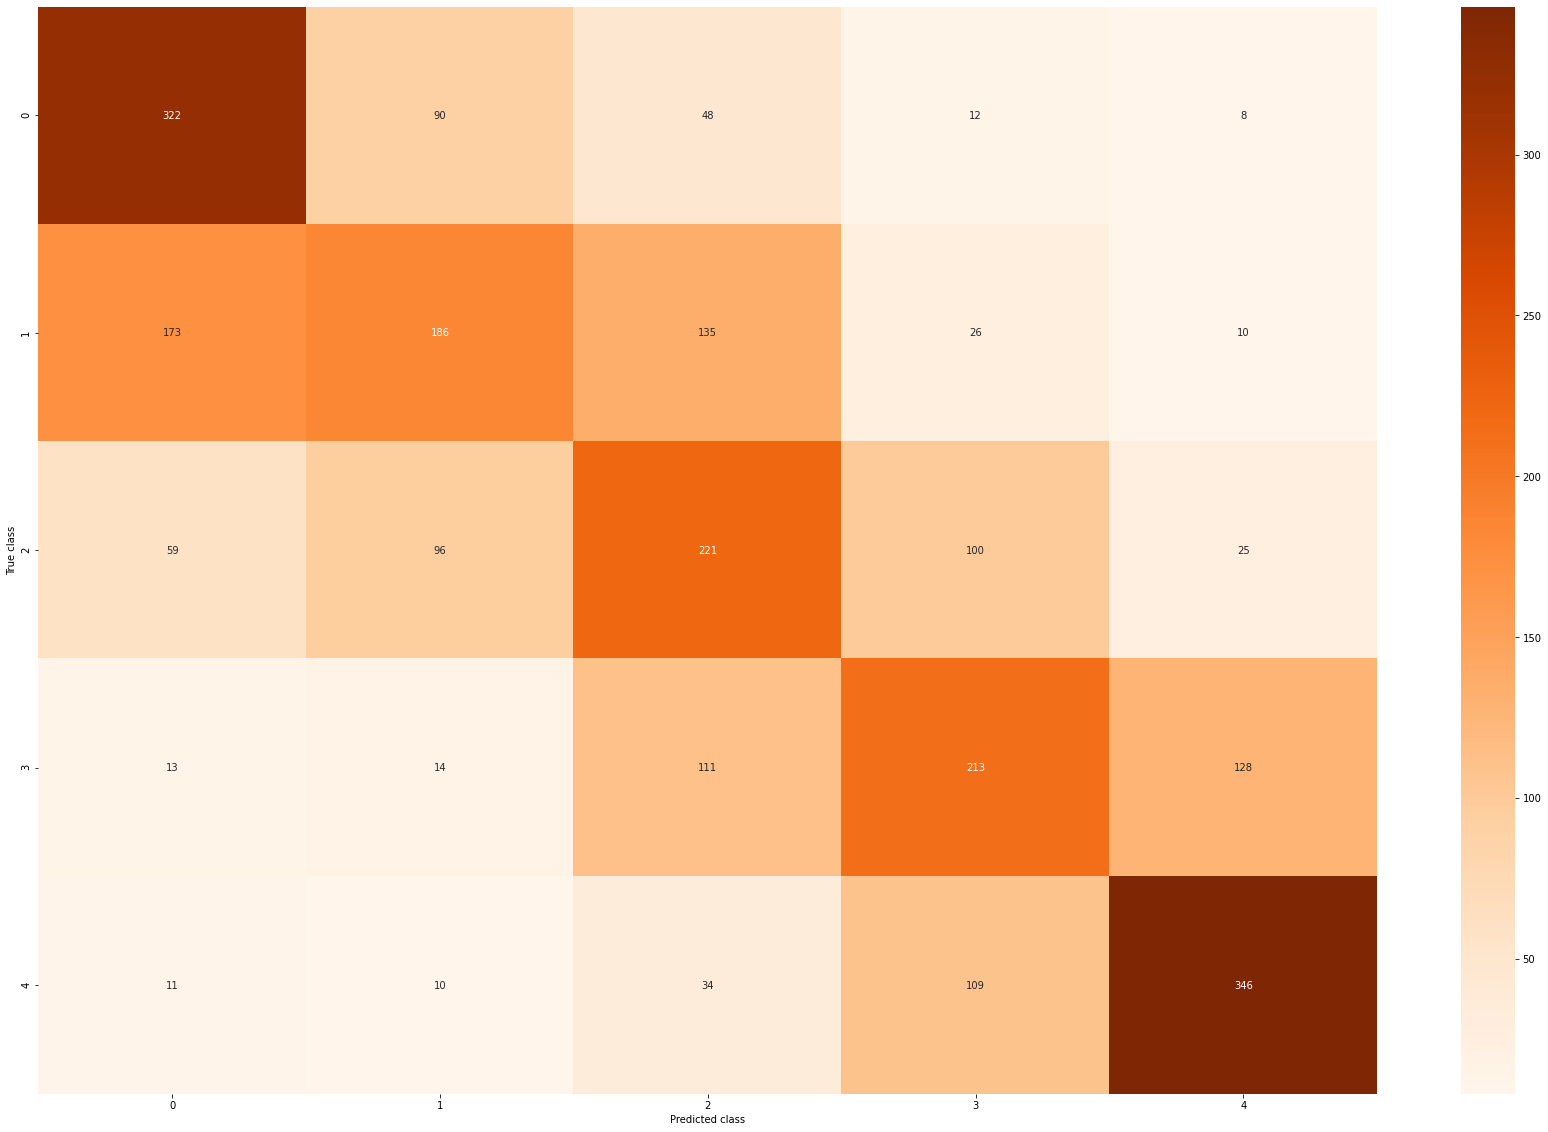

In [ ]:
eval_model(model,padded_rev_test,y_test) ## NO mejora mucho la bilstm sin atentción 